# Baseline Evaluation

Evaluating the baseline model. 

The baseline models uses *ASR* (`whisper-tiny` model) to predict the tranctipt of the speech and then uses `multilingual-e5-small` to enocde both the **true transcript** and the **predicted transcript**

In [2]:
import torch
import os, re, string, unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoProcessor, pipeline
import numpy as np

/home/sted/.venvs/diplomatiki/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

- We use the [HParl: Hellenic Parliamentary Speech Corpus](https://inventory.clarin.gr/corpus/1602) which contains 120 hours of recorded speech along with transcriptions.
- For accessing we use **HuggingFace**'s [`hparl`](https://huggingface.co/datasets/ddamianos/hparl)

In [2]:
# Base directory for the dataset
base = "/mnt/h/"

# HuggingFace caches
os.environ["HF_DATASETS_CACHE"] = f"{base}/datasets"
os.environ["HF_HOME"] = base
os.environ["TRANSFORMERS_CACHE"] = f"{base}/models"

# Base directory for the dataset
orig_ds = load_dataset('ddamianos/hparl',
                       cache_dir=os.environ["HF_DATASETS_CACHE"])

In [3]:
# Keep only the 'sentence' and 'audio' columns in the test split
keep_cols = ['sentence', 'audio']
cols_to_remove = [c for c in orig_ds['test'].column_names if c not in keep_cols]
if cols_to_remove:
    orig_ds['test'] = orig_ds['test'].remove_columns(cols_to_remove)

# Display first 10 rows from test dataset
orig_ds['test'].flatten().to_pandas().head(10)

,sentence,audio.array,audio.sampling_rate
0,[UNK] λυθει μεχρι το τελος του χρονου ετσι στο...,"[-0.0021362305, 0.04498291, 0.07507324, 0.1015...",16000
1,[UNK] που εγινε αναφορα για την [UNK],"[-0.07055664, -0.041168213, -0.0050354004, 0.0...",16000
2,[UNK] η τροποποιηση του αρθρου εβδομηνταδυο το...,"[-0.0076293945, 0.012207031, 0.028289795, 0.01...",16000
3,[UNK] που εχουν συναφθει πριν την εναρξη ισχυο...,"[-0.06365967, 0.052703857, 0.016601562, -0.049...",16000
4,εχουν εφαρμογη τα [UNK],"[0.01171875, 0.020080566, 0.022888184, 0.02709...",16000
5,[UNK] στον κωδικα φορολογιας εισοδηματος,"[-0.07522583, -0.086364746, -0.120910645, -0.1...",16000
6,του κωδικα φπα και τα εισιτηρια των θεατρικων ...,"[-0.019500732, -0.032409668, -0.03302002, -0.0...",16000
7,[UNK] αν δεν το καναμε τωρα θα επρεπε να παει ...,"[0.00076293945, 0.002960205, 0.0026855469, 0.0...",16000
8,οποτε θα ηταν ενα ζητημα για τους ανθρωπους πο...,"[-0.0063476562, -0.006591797, -0.004211426, -0...",16000
9,[UNK] απο την αρχη του ετους δινουμε μια δυνατ...,"[-0.029876709, 0.019592285, 0.018554688, -0.03...",16000


## Preprocessing
We must preprocess the audio and the text in order to be read for consumption by the model

### Text preprocessing
1. Remove `[UNC]`
2. Normalize Text

In [4]:
def preprocess_sentence(examples):
    """
    Preprocess the sentence column (batch):
    1. Remove [UNK] tokens
    2. Remove punctuation
    3. Normalize text (lowercase, whitespace, unicode normalization)
    4. Tokenize with multilingual-e5-small tokenizer
    """
    texts = examples['sentence']
    
    # Process all texts
    processed_texts = []
    for text in texts:
        # Remove [UNK] tokens
        text = re.sub(r'\[UNK\]', '', text)
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Unicode normalization (NFKD)
        text = unicodedata.normalize('NFKD', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        processed_texts.append(text)
    
    return {'gt-transcription': processed_texts}

In [5]:
# Test the functions on a sample
sample = orig_ds['test'][3:4].copy()
print("Text Before:", sample['sentence'])
processed_text = preprocess_sentence(sample)
print("Text After:", processed_text['gt-transcription'])

Text Before: ['[UNK] που εχουν συναφθει πριν την εναρξη ισχυος του παροντος κωδικα ']
Text After: ['που εχουν συναφθει πριν την εναρξη ισχυος του παροντος κωδικα']


### Audio Preprocessing
1. Resample to $16\text{kHz}$
2. Run `whisper-tiny` preprocessor


In [6]:
asr_pipeline = pipeline("automatic-speech-recognition",
                        model="openai/whisper-small",
                        device=0)

Device set to use cuda:0


In [ ]:
def transcribe_audio(examples):
    """
    Preprocess the audio column (batch):
    1. Transcribe audio in Greek using ASR pipeline
    2. Tokenize transcriptions with e5
    """
    waveforms = list(examples['audio.array'])
    # Transcribe using ASR pipeline in Greek
    results = asr_pipeline(waveforms, generate_kwargs={"language": "el"})
    
    return {
        'predicted-transcription': [result['text'] for result in results]
    }

### Mapping Dataset

In [ ]:
def preprocess_batch(examples):
    """
    Combined preprocessing for text and audio:
    - Text: ground truth transcription, tokenized with e5
    - Audio: predicted transcription from ASR pipeline, tokenized with e5
    """
    gt_transcriptions = preprocess_sentence(examples)
    predicted_transcriptions = transcribe_audio(examples)
    return {**gt_transcriptions, **predicted_transcriptions}

In [9]:
# Test the combined preprocessing function on a small batch
test_ds = orig_ds['test'].select(range(5))
test_ds.flatten().with_format("numpy").map(preprocess_batch, batched=True, batch_size=2).to_pandas().head(3)

Map: 100%|██████████| 5/5 [00:04<00:00,  1.02 examples/s]


,sentence,audio.array,audio.sampling_rate,gt-transcription,predicted-transcription
0,[UNK] λυθει μεχρι το τελος του χρονου ετσι στο...,"[-0.0021362305, 0.04498291, 0.07507324, 0.1015...",16000,λυθει μεχρι το τελος του χρονου ετσι στο πρωτο...,"να λυθούν με χτέλεις του χρόνου. Έτσι, στο πρ..."
1,[UNK] που εγινε αναφορα για την [UNK],"[-0.07055664, -0.041168213, -0.0050354004, 0.0...",16000,που εγινε αναφορα για την,όπου έγινε η αναφορά για την Εθνία.
2,[UNK] η τροποποιηση του αρθρου εβδομηνταδυο το...,"[-0.0076293945, 0.012207031, 0.028289795, 0.01...",16000,η τροποποιηση του αρθρου εβδομηνταδυο του κωδι...,η τροπής του άρθου 72 του κόδικα φορολογιές Σ...


In [ ]:
# Apply preprocessing to the test split
print("Processing test split...")
preprocessed_ds = orig_ds['test'].with_format("numpy").flatten().map(
    preprocess_batch,
    batched=True,
    batch_size=8)

print("Preprocessing complete!")
print(f"New dataset columns: {preprocessed_ds.column_names}")

Processing test split...


Map:  68%|██████▊   | 5864/8679 [1:42:53<55:18,  1.18s/ examples]  

In [ ]:
# Save the preprocessed dataset
save_path = "/mnt/h/hparl-transcribed"

In [ ]:
# Create directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the preprocessed dataset
preprocessed_ds.save_to_disk(save_path)

print(f"Dataset saved to {save_path}")
print(f"Dataset info:")
print(f"  Number of samples: {len(preprocessed_ds)}")
print(f"  Columns: {preprocessed_ds.column_names}")

Saving the dataset (1/1 shards): 100%|██████████| 8679/8679 [00:00<00:00, 275660.63 examples/s]

Dataset saved to /mnt/h/hparl-transcribed
Dataset info:
  Number of samples: 8679
  Columns: ['gt_transcription', 'predicted_transcription']


In [ ]:
preprocessed_ds = load_from_disk(save_path)
preprocessed_ds.to_pandas().head(3)

,gt_transcription,predicted_transcription
0,λυθει μεχρι το τελος του χρονου ετσι στο πρωτο...,"Αυτό πρώτο κομμάτι, Αυτό πρώτο κομμάτι, Αυτό ..."
1,που εγινε αναφορα για την,Εγώ που έγινε για να φορά.
2,η τροποποιηση του αρθρου εβδομηνταδυο του κωδι...,η τροποίης του άρθρωδε με τα δύο του κόδικα φ...


## Evaluation

We want to compute metrics in order to evaluate the performance of the ASR model.

```md
╔════════════════════════════════════════════════════════════════════════════╗
║               E5 RETRIEVAL EVALUATION STRATEGY                             ║
╚════════════════════════════════════════════════════════════════════════════╝

┌──────────────────────────┐              ┌──────────────────────────┐
│  GROUND TRUTH            │              │  PREDICTED               │
│  TRANSCRIPTIONS          │              │  TRANSCRIPTIONS          │
│  (from dataset)          │              │  (from whisper-tiny)     │
└──────────┬───────────────┘              └──────────┬───────────────┘
           │                                         │
           │ "encode as query"                       │ "encode as passage"
           │ prefix: "query: "                       │ prefix: "passage: "
           │                                         │
           ▼                                         ▼
    ┌─────────────┐                          ┌─────────────┐
    │   E5-Small  │                          │   E5-Small  │
    │  Encoder    │                          │  Encoder    │
    └──────┬──────┘                          └──────┬──────┘
           │                                        │
           ▼                                        ▼
    ┌──────────────┐                        ┌──────────────┐
    │  Query       │                        │  Passage     │
    │  Embeddings  │                        │  Embeddings  │
    │  (768-dim)   │                        │  (768-dim)   │
    └──────┬───────┘                        └──────┬───────┘
           │                                       │
           │ normalize (L2)                        │ normalize (L2)
           │                                       │
           ▼                                       ▼
    ┌──────────────┐                        ┌──────────────┐
    │  Normalized  │                        │  Normalized  │
    │  Queries     │                        │  Passages    │
    │  Q[n, 768]   │                        │  P[n, 768]   │
    └──────┬───────┘                        └──────┬───────┘
           │                                       │
           └───────────────────┬───────────────────┘
                               │
                               │ Compute Similarity
                               │ Similarity = Q @ P.T
                               │ (dot-product)
                               │
                               ▼
                        ┌──────────────────┐
                        │ Similarity Matrix│
                        │ [n, n]           │
                        │ Score(q_i, p_j)  │
                        └────────┬─────────┘
                                 │
                                 │ For each query:
                                 │ - Rank passages by similarity
                                 │ - Check if gold passage in top-k
                                 │
                                 ▼
                        ┌──────────────────┐
                        │  Recall@k Score  │
                        │  = Hits / Total  │
                        │  (k=1,5,10,...)  │
                        └──────────────────┘
```

### Tokenization

In [ ]:
# Initialize e5 tokenizer
e5_tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-small')

In [ ]:
def tokenize_batch(examples):
    """
    Tokenize both ground truth and predicted transcriptions.
    
    Args:
        examples: batch from dataset with 'gt-transcription' and 'predicted-transcription'
    
    Returns:
        Dictionary with tokenized outputs:
        - 'gt_input_ids', 'gt_attention_mask': for ground truth
        - 'pred_input_ids', 'pred_attention_mask': for predictions
    """
    # Get transcriptions
    gt_texts = examples['gt_transcription']
    pred_texts = examples['predicted_transcription']
    
    # Add E5 prefixes for query and passage
    gt_texts_prefixed = [f"query: {text}" for text in gt_texts]
    pred_texts_prefixed = [f"passage: {text}" for text in pred_texts]
    
    # Tokenize ground truth (queries)
    gt_tokens = e5_tokenizer(
        gt_texts_prefixed,
        padding='max_length',
        max_length=128,
        truncation=True,
        return_tensors='pt'
    )
    
    # Tokenize predictions (passages)
    pred_tokens = e5_tokenizer(
        pred_texts_prefixed,
        padding='max_length',
        max_length=128,
        truncation=True,
        return_tensors='pt'
    )
    
    return {
        'gt_input_ids': gt_tokens['input_ids'],
        'gt_attention_mask': gt_tokens['attention_mask'],
        'pred_input_ids': pred_tokens['input_ids'],
        'pred_attention_mask': pred_tokens['attention_mask'],
    }

In [ ]:
# Test tokenization on a small batch
test_batch = preprocessed_ds.select(range(2))
tokenized = tokenize_batch(test_batch)

print("Tokenization successful!")
print(f"GT input_ids shape: {tokenized['gt_input_ids'].shape}")
print(f"GT attention_mask shape: {tokenized['gt_attention_mask'].shape}")
print(f"Pred input_ids shape: {tokenized['pred_input_ids'].shape}")
print(f"Pred attention_mask shape: {tokenized['pred_attention_mask'].shape}")

Tokenization successful!
GT input_ids shape: torch.Size([2, 128])
GT attention_mask shape: torch.Size([2, 128])
Pred input_ids shape: torch.Size([2, 128])
Pred attention_mask shape: torch.Size([2, 128])


### Embedding Model

In [ ]:
from transformers import AutoModel
import torch.nn as nn
import torch.nn.functional as F

class E5EmbeddingModel(nn.Module):
    """
    E5 Embedding model with average pooling.
    
    Takes input_ids and attention_mask and returns normalized embeddings.
    """
    def __init__(self, model_name='intfloat/multilingual-e5-small'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
    
    def forward(self, input_ids, attention_mask):
        """
        Forward pass to compute embeddings.
        
        Args:
            input_ids: (batch_size, seq_length) token IDs
            attention_mask: (batch_size, seq_length) attention mask (1 for real tokens, 0 for padding)
        
        Returns:
            embeddings: (batch_size, embedding_dim) normalized embeddings
        """
        # Get model outputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get last hidden state (token embeddings)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_length, embedding_dim)
        
        # Average pooling: mask padding tokens and compute mean
        # Expand attention_mask to match embedding dimension
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        
        # Apply mask and sum
        sum_embeddings = torch.sum(last_hidden_state * mask_expanded, dim=1)
        
        # Divide by sum of attention_mask to get mean
        sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
        
        # Normalize embeddings (L2 normalization)
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        return embeddings

In [ ]:
# Instantiate the model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
e5_model = E5EmbeddingModel().to(device)
e5_model.eval()

print(f"E5 Embedding model loaded on {device}")
print(f"Model info:")
print(f"  Embedding dimension: {e5_model.model.config.hidden_size}")
print(f"  Model: {e5_model.model.config.model_type}")

E5 Embedding model loaded on cuda:0
Model info:
  Embedding dimension: 384
  Model: bert


### Embedding Vectors

In [ ]:
def compute_embeddings(examples, device='cuda:0'):
    """
    Compute embedding vectors for ground truth and predicted transcriptions.
    
    This function is designed to be used with dataset.map(compute_embeddings, batched=True)
    
    Args:
        examples: batch from dataset with 'gt_transcription' and 'predicted_transcription'
    
    Returns:
        Dictionary with:
        - 'gt_embeddings': numpy array of shape (batch_size, 768)
        - 'pred_embeddings': numpy array of shape (batch_size, 768)
    """
    # Tokenize batch
    tokenized = tokenize_batch(examples)
    
    # Move tokenized inputs to device
    gt_input_ids = tokenized['gt_input_ids'].to(device)
    gt_attention_mask = tokenized['gt_attention_mask'].to(device)
    pred_input_ids = tokenized['pred_input_ids'].to(device)
    pred_attention_mask = tokenized['pred_attention_mask'].to(device)
    
    # Compute embeddings (no gradient computation)
    with torch.no_grad():
        gt_emb = e5_model(gt_input_ids, gt_attention_mask)
        pred_emb = e5_model(pred_input_ids, pred_attention_mask)
    
    # Convert to numpy and return
    return {
        'gt_embeddings': gt_emb.cpu().numpy(),
        'pred_embeddings': pred_emb.cpu().numpy()
    }

In [ ]:
# Compute embeddings for all samples using .map()
print("Computing embeddings...")

dataset = preprocessed_ds.map(compute_embeddings,
                              batched=True,
                              batch_size=32,
                              desc="Computing embeddings")

print(f"\n✓ Embeddings computed!")
print(f"Dataset columns: {dataset.column_names}")
print(f"Total samples: {len(dataset)}")
print(f"Embedding dimension: 384")
print(f"All embeddings are L2-normalized")

dataset.to_pandas().head(3)

Computing embeddings...

✓ Embeddings computed!
Dataset columns: ['gt_transcription', 'predicted_transcription', 'gt_embeddings', 'pred_embeddings']
Total samples: 8679
Embedding dimension: 384
All embeddings are L2-normalized


,gt_transcription,predicted_transcription,gt_embeddings,pred_embeddings
0,λυθει μεχρι το τελος του χρονου ετσι στο πρωτο...,"Αυτό πρώτο κομμάτι, Αυτό πρώτο κομμάτι, Αυτό ...","[0.053909373, -0.017527323, 0.019960463, -0.08...","[0.0829575, -0.0315561, 0.0035364318, -0.07474..."
1,που εγινε αναφορα για την,Εγώ που έγινε για να φορά.,"[0.061142545, -0.049206037, -0.025038881, -0.0...","[0.05731134, -0.035867907, -0.017705107, -0.07..."
2,η τροποποιηση του αρθρου εβδομηνταδυο του κωδι...,η τροποίης του άρθρωδε με τα δύο του κόδικα φ...,"[0.070775226, -0.075505435, -0.035674702, -0.0...","[0.051611472, -0.034394227, -0.04904967, -0.07..."


### Similarity Matrix

Compute similarity scores between query (GT) and passage (predicted) embeddings in batches to manage memory.


In [ ]:
def compute_similarity_matrix_batched(dataset, batch_size=256, save_path=None):
    """
    Compute similarity matrix in batches to manage memory efficiently.
    
    For large datasets, we compute similarity row-by-row (or in small batches):
    - Load query embeddings in chunks
    - Compute dot product with all passage embeddings
    - Save results to file or accumulate
    
    Args:
        dataset: HuggingFace dataset with 'gt_embeddings' and 'pred_embeddings'
        batch_size: number of queries to process at once (default: 256)
        save_path: if provided, saves similarity matrix to disk
    
    Returns:
        similarity_matrix: numpy array of shape (n_samples, n_samples)
    """
    import numpy as np
    
    n_samples = len(dataset)
    
    # Convert embeddings to numpy arrays
    print("Loading embeddings...")
    gt_embeddings_list = []
    pred_embeddings_list = []
    
    for batch in dataset.iter(batch_size=1000):
        gt_embeddings_list.append(np.array(batch['gt_embeddings']))
        pred_embeddings_list.append(np.array(batch['pred_embeddings']))
    
    gt_embeddings = np.concatenate(gt_embeddings_list, axis=0)
    pred_embeddings = np.concatenate(pred_embeddings_list, axis=0)
    
    print(f"  GT embeddings shape: {gt_embeddings.shape}")
    print(f"  Pred embeddings shape: {pred_embeddings.shape}")
    
    # Compute similarity matrix in batches
    print(f"\nComputing similarity matrix ({n_samples} x {n_samples})...")
    similarity_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)
    
    for i in range(0, n_samples, batch_size):
        batch_end = min(i + batch_size, n_samples)
        batch_size_actual = batch_end - i
        
        # Get query batch
        query_batch = gt_embeddings[i:batch_end]  # (batch_size_actual, 768)
        
        # Compute similarity with all passages via dot product
        # query_batch @ pred_embeddings.T = (batch_size_actual, n_samples)
        similarity_batch = np.dot(query_batch, pred_embeddings.T)
        
        # Store in matrix
        similarity_matrix[i:batch_end] = similarity_batch
        
        if (i // batch_size + 1) % 5 == 0:
            print(f"  Processed {batch_end}/{n_samples} queries")
    
    print(f"✓ Similarity matrix computed!")
    print(f"  Shape: {similarity_matrix.shape}")
    print(f"  Min similarity: {similarity_matrix.min():.4f}")
    print(f"  Max similarity: {similarity_matrix.max():.4f}")
    print(f"  Mean similarity: {similarity_matrix.mean():.4f}")
    
    if save_path:
        print(f"\nSaving similarity matrix to {save_path}...")
        np.save(save_path, similarity_matrix)
        print(f"✓ Saved!")
    
    return similarity_matrix


In [ ]:
# Compute similarity matrix with batching
similarity_path = "/mnt/h/similarity_matrix.npy"
similarity_matrix = compute_similarity_matrix_batched(
    dataset, 
    batch_size=256,
    save_path=similarity_path
)

Loading embeddings...
  GT embeddings shape: (8679, 384)
  Pred embeddings shape: (8679, 384)

Computing similarity matrix (8679 x 8679)...
  Processed 1280/8679 queries
  Processed 2560/8679 queries
  Processed 3840/8679 queries
  Processed 5120/8679 queries
  Processed 6400/8679 queries
  Processed 7680/8679 queries
✓ Similarity matrix computed!
  Shape: (8679, 8679)
  Min similarity: 0.6907
  Max similarity: 0.9699
  Mean similarity: 0.8184

Saving similarity matrix to /mnt/h/similarity_matrix.npy...
✓ Saved!


### Recall@k

In [ ]:
similarity_matrix = torch.from_numpy(similarity_matrix)
topk = torch.topk(similarity_matrix, k=5, dim=1)

# Check if each row i contains index i in its top-5 indices
row_indices = torch.arange(len(topk.indices)).unsqueeze(1)  # Shape: (n, 1)
matches = (topk.indices == row_indices).any(dim=1)  # Check if i appears in row i's top-5

# Calculate Recall@5
recall_at_5 = matches.float().mean().item()

print(f"Recall@5: {recall_at_5:.4f}")
print(f"Matches: {matches.sum().item()}/{len(matches)}")
print(f"\nFirst 10 rows:")
for i in range(min(10, len(matches))):
    in_top5 = "✓" if matches[i] else "✗"
    print(f"  Row {i}: {in_top5} | Top-5 indices: {topk.indices[i].tolist()}")

Recall@5: 0.6337
Matches: 5500/8679

First 10 rows:
  Row 0: ✗ | Top-5 indices: [534, 991, 2527, 1202, 4657]
  Row 1: ✗ | Top-5 indices: [81, 4379, 7524, 7734, 2861]
  Row 2: ✓ | Top-5 indices: [2336, 2, 2213, 2191, 2825]
  Row 3: ✓ | Top-5 indices: [3, 8185, 5911, 3455, 8213]
  Row 4: ✓ | Top-5 indices: [4, 2701, 8648, 3817, 7895]
  Row 5: ✓ | Top-5 indices: [5, 2192, 4474, 1417, 7757]
  Row 6: ✓ | Top-5 indices: [6, 506, 604, 2885, 7798]
  Row 7: ✓ | Top-5 indices: [7, 1007, 8161, 4655, 2235]
  Row 8: ✓ | Top-5 indices: [8, 8079, 4435, 811, 4424]
  Row 9: ✓ | Top-5 indices: [9, 8326, 8578, 5861, 686]


In [ ]:
def compute_recall_at_k(similarity_matrix, k):
    """
    Compute Recall@k metric from a similarity matrix.
    
    For each row i, checks if the diagonal element (index i) appears 
    in the top-k highest similarity scores.
    
    Args:
        similarity_matrix: torch.Tensor of shape (n, n) or numpy array
        k: number of top results to consider
    
    Returns:
        recall_at_k: float, the recall@k score (0.0 to 1.0)
    """
    # Convert to torch if numpy
    if isinstance(similarity_matrix, np.ndarray):
        similarity_matrix = torch.from_numpy(similarity_matrix)
    
    # Get top-k indices for each row
    topk_values, topk_indices = torch.topk(similarity_matrix, k=k, dim=1)
    
    # Check if diagonal element i appears in row i's top-k
    row_indices = torch.arange(len(topk_indices)).unsqueeze(1)  # Shape: (n, 1)
    matches = (topk_indices == row_indices).any(dim=1)  # Check if i appears in row i's top-k
    
    # Compute recall@k
    recall_at_k = matches.float().mean().item()
    
    return recall_at_k


### Results

In [ ]:
# Compute Recall@k for different values of k
k_values = [1, 3, 5, 10, 15, 20]
results = {k: compute_recall_at_k(similarity_matrix, k) 
           for k in k_values}

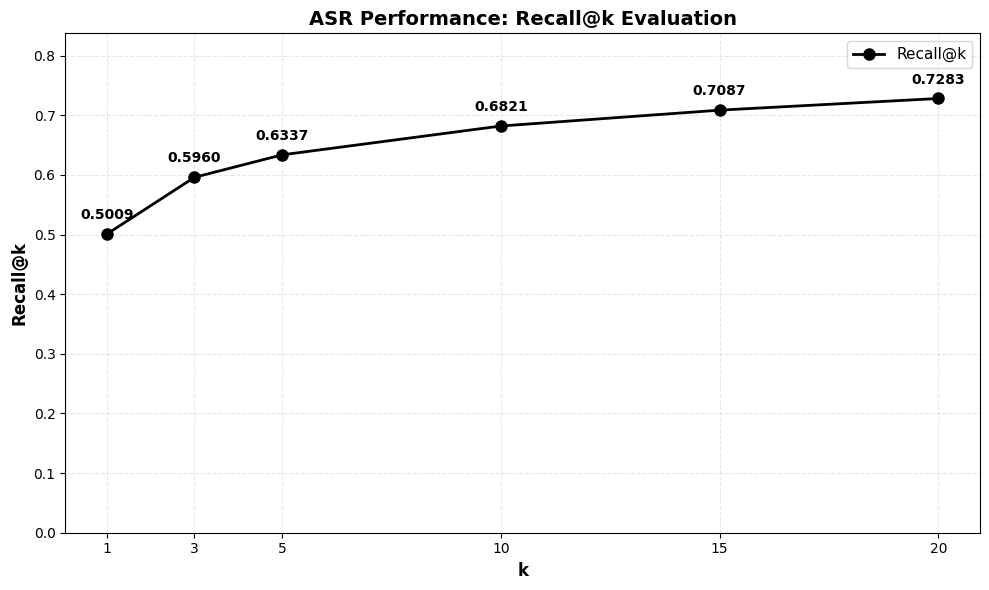

In [ ]:
# Plot Recall@k results
fig, ax = plt.subplots(figsize=(10, 6))

k_vals = list(results.keys())
recall_vals = list(results.values())

# Create line plot with circle markers
ax.plot(k_vals, recall_vals, 'o-', color='black', linewidth=2, markersize=8, label='Recall@k')

# Add value labels on data points
for k, recall in zip(k_vals, recall_vals):
    ax.text(k, recall + 0.02, f'{recall:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
ax.set_xlabel('k', fontsize=12, fontweight='bold')
ax.set_ylabel('Recall@k', fontsize=12, fontweight='bold')
ax.set_title('ASR Performance: Recall@k Evaluation', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(recall_vals) * 1.15)
ax.set_xticks(k_vals)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

# Add horizontal line at y=1 for reference
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Perfect Recall')

plt.tight_layout()
plt.show()


In [ ]:
# Print summary
print("\n" + "="*50)
print("SUMMARY: ASR Baseline Evaluation")
print("="*50)
print(f"Model: Whisper-tiny (Greek) + E5-small embeddings")
print(f"Metric: Recall@k (diagonal element in top-k)")
print(f"\nResults:")
for k, recall in results.items():
    print(f"  Recall@{k:2d}: {recall:.4f} ({int(recall * 100)}%)")
print("="*50)


SUMMARY: ASR Baseline Evaluation
Model: Whisper-tiny (Greek) + E5-small embeddings
Metric: Recall@k (diagonal element in top-k)

Results:
  Recall@ 1: 0.5009 (50%)
  Recall@ 3: 0.5960 (59%)
  Recall@ 5: 0.6337 (63%)
  Recall@10: 0.6821 (68%)
  Recall@15: 0.7087 (70%)
  Recall@20: 0.7283 (72%)
